<a href="https://colab.research.google.com/github/Brahmani1237/NLP-2403A52020/blob/main/NLP_Lab12_4_TextCNN_PretrainedEmbeddings_M_Brahmani_2403A52020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================
# STEP 1 — IMPORT LIBRARIES
# ==============================

import numpy as np                     # For numerical operations
import pandas as pd                    # For handling dataset
import re                              # For text cleaning using regex
import torch                           # PyTorch main library
import torch.nn as nn                  # Neural network module
import torch.optim as optim            # Optimizers
from sklearn.model_selection import train_test_split  # Train-test split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader      # For batching data


In [ ]:
# ==============================
# STEP 2 — LOAD DATASET
# ==============================

# Load SMS Spam dataset (tab separated file)
df = pd.read_csv("/content/SMSSpamCollection", sep="\t", header=None)

# Rename columns
df.columns = ["label", "text"]

# Convert labels: ham=0, spam=1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print(df.head())
print(df['label'].value_counts())


   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
label
0    4825
1     747
Name: count, dtype: int64


In [ ]:
# ==============================
# STEP 3 — TEXT CLEANING
# ==============================

# Function to clean text
def clean_text(text):
    text = text.lower()                          # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)      # Remove numbers & symbols
    return text

# Apply cleaning
df['text'] = df['text'].apply(clean_text)


In [ ]:
# ==============================
# STEP 4 — TOKENIZATION
# ==============================

# Split sentence into words
df['tokens'] = df['text'].apply(lambda x: x.split())

print(df['tokens'].head())


0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, a, wkly, comp, to, win, fa, ...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, dont, think, he, goes, to, usf, he, l...
Name: tokens, dtype: object


In [10]:
# ==============================
# STEP 5 — BUILD VOCABULARY
# ==============================

# Add special tokens
vocab = {"<PAD>": 0, "<UNK>": 1}
index = 2

# Create word-to-index mapping
for tokens in df['tokens']:
    for word in tokens:
        if word not in vocab:
            vocab[word] = index
            index += 1

print("Vocabulary Size:", len(vocab))


Vocabulary Size: 8631


In [ ]:
# ==============================
# STEP 6 — ENCODING + PADDING
# ==============================

max_len = 50   # Maximum sequence length

def encode(tokens):
    # Convert words to numbers
    seq = [vocab.get(word, vocab["<UNK>"]) for word in tokens]

    # Padding
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    else:
        seq = seq[:max_len]

    return seq

df['encoded'] = df['tokens'].apply(encode)


In [ ]:
# ==============================
# STEP 7 — TRAIN TEST SPLIT
# ==============================

X = np.array(df['encoded'].tolist())
y = np.array(df['label'].tolist())

# Stratify ensures balanced class split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 4457
Testing samples: 1115


In [13]:
# ==============================# STEP 8 — LOAD GLOVE EMBEDDINGS# ==============================embedding_dim = 100  # Using 100D GloVe# Initialize embedding matrix with random valuesembedding_matrix = np.random.uniform(-0.25, 0.25, (len(vocab), embedding_dim))# Download pretrained GloVe file!wget -P /content/ http://nlp.stanford.edu/data/glove.6B.zip!unzip /content/glove.6B.zip.3 -d /content/# Load pretrained GloVe file (download glove.6B.100d.txt first)with open("/content/glove.6B.100d.txt", encoding="utf8") as f:    for line in f:        values = line.split()        word = values[0]        vector = np.asarray(values[1:], dtype='float32')        # If word exists in our vocabulary, replace random vector        if word in vocab:            idx = vocab[word]            embedding_matrix[idx] = vector

In [14]:
# ==============================
# STEP 9 — CUSTOM DATASET CLASS
# ==============================

class SMSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = SMSDataset(X_train, y_train)
test_dataset = SMSDataset(X_test, y_test)

# Create dataloaders (batch training)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [15]:
# ==============================
# STEP 10 — DEFINE 1D CNN MODEL
# ==============================

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix):
        super(TextCNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Load pretrained weights
        self.embedding.weight = nn.Parameter(
            torch.tensor(embedding_matrix, dtype=torch.float32)
        )

        # Freeze embeddings (do not train them)
        self.embedding.weight.requires_grad = False

        # Convolution layers with different filter sizes
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3)
        self.conv2 = nn.Conv1d(embedding_dim, 128, kernel_size=4)
        self.conv3 = nn.Conv1d(embedding_dim, 128, kernel_size=5)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 3, 1)

    def forward(self, x):
        x = self.embedding(x)         # (batch, seq_len, embed_dim)
        x = x.permute(0, 2, 1)        # Change shape for CNN

        # Apply convolution + global max pooling
        c1 = torch.relu(self.conv1(x))
        c1 = torch.max_pool1d(c1, c1.shape[2]).squeeze(2)

        c2 = torch.relu(self.conv2(x))
        c2 = torch.max_pool1d(c2, c2.shape[2]).squeeze(2)

        c3 = torch.relu(self.conv3(x))
        c3 = torch.max_pool1d(c3, c3.shape[2]).squeeze(2)

        # Concatenate all filters
        x = torch.cat((c1, c2, c3), 1)

        x = self.dropout(x)
        x = torch.sigmoid(self.fc(x))

        return x


In [16]:
# ==============================
# STEP 11 — TRAINING
# ==============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(len(vocab), embedding_dim, embedding_matrix).to(device)

criterion = nn.BCELoss()              # Binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


Epoch 1, Loss: 0.3872393024819238
Epoch 2, Loss: 0.22266736456326075
Epoch 3, Loss: 0.12978306114673616
Epoch 4, Loss: 0.09178525337151118
Epoch 5, Loss: 0.07022140731236765
Epoch 6, Loss: 0.05258489535855396
Epoch 7, Loss: 0.040704883874527045
Epoch 8, Loss: 0.03309474341305239
Epoch 9, Loss: 0.02622375053885792
Epoch 10, Loss: 0.021332324236365302


In [17]:
# ==============================
# STEP 12 — EVALUATION
# ==============================

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()

        preds = (outputs > 0.5).int().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Print metrics
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision:", precision_score(all_labels, all_preds))
print("Recall:", recall_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Accuracy: 0.9721973094170404
Precision: 0.9836065573770492
Recall: 0.8053691275167785
F1 Score: 0.8856088560885609
Confusion Matrix:
 [[964   2]
 [ 29 120]]


In [18]:
# ==========================================
# TRAINING CELL
# ==========================================

epochs = 10
loss_list = []
accuracy_list = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).int().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    accuracy_list.append(acc)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")


Epoch 1, Loss: 0.0196, Accuracy: 0.9740
Epoch 2, Loss: 0.0158, Accuracy: 0.9722
Epoch 3, Loss: 0.0125, Accuracy: 0.9740
Epoch 4, Loss: 0.0111, Accuracy: 0.9740
Epoch 5, Loss: 0.0092, Accuracy: 0.9740
Epoch 6, Loss: 0.0083, Accuracy: 0.9749
Epoch 7, Loss: 0.0076, Accuracy: 0.9758
Epoch 8, Loss: 0.0066, Accuracy: 0.9758
Epoch 9, Loss: 0.0057, Accuracy: 0.9731
Epoch 10, Loss: 0.0052, Accuracy: 0.9731


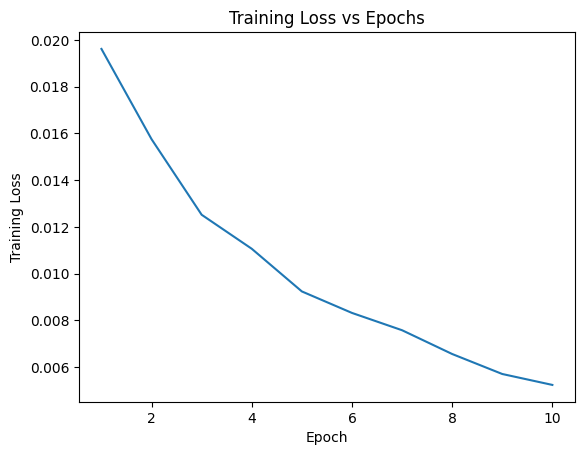

In [19]:
# ==========================================
# GRAPH 1 — TRAINING LOSS
# ==========================================

import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, epochs+1), loss_list)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()


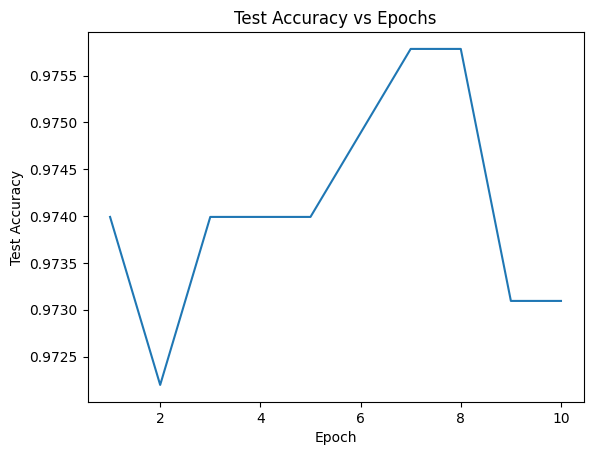

In [20]:
# ==========================================
# GRAPH 2 — TEST ACCURACY
# ==========================================

plt.figure()
plt.plot(range(1, epochs+1), accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Epochs")
plt.show()


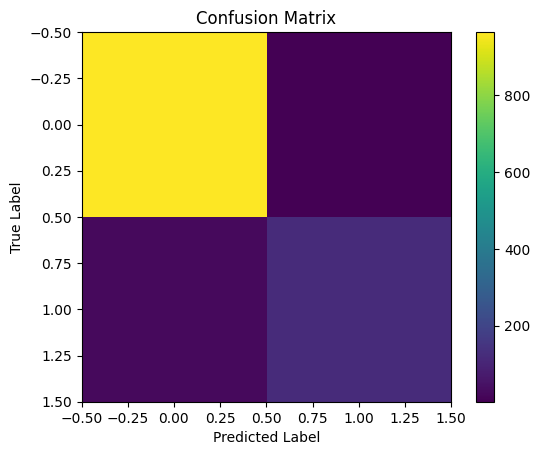

In [21]:
# ==========================================
# GRAPH 3 — CONFUSION MATRIX
# ==========================================

cm = confusion_matrix(all_labels, all_preds)

plt.figure()
plt.imshow(cm)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()
